In [1]:
'''
This script is to calculate the delta B/ B and delta B

Author: Sayantan
Date : 5 May 2018

Modified : 7 August 2018
         : added the error in the variation of rc and 
         

'''

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from scipy import integrate
import os.path
from decimal import Decimal # to print in scientific notation
import CFS_functions as cfs
import function as mf

In [2]:
# parameters that are needed.
distinpc = 120.0
pc = 3.0857e+18 # cm 
AU = 1.496e+13  # cm
amu = 1.6605402e-24 # g
mu = 2.33*amu
mperH2= 2.8* amu
Msun=1.9891e+33 # g
G = 6.67259e-8 # cm3 g-1 s-2
# 1 Gauss = g^(1/2) * cm^{-1/2}* s^-1
##

[  2.89347635e+22   1.91541149e+01   4.11330255e-01]
[  9.63634013e+20   7.67252448e+00   1.64410235e-01]


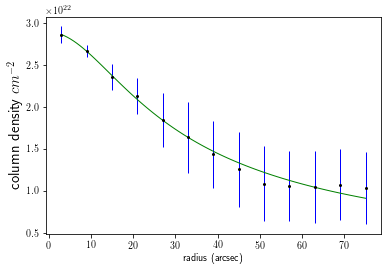

In [3]:
## fitting the plummer type fucntion to the column density profile
# fileName = "./columndensity_data/H-MM1_column_density.dat"
# fileName = "./columndensity_data/H-MM2_column_density.dat"
# fileName = "./columndensity_data/OpHCN_column_density.dat"
# fileName = "./columndensity_data/OpH-C_column_density.dat"
# fileName = "./columndensity_data/OpH-E_column_density.dat"
# fileName = "./columndensity_data/OpH-X_column_density.dat"
fileName = "./columndensity_data/OpHFE_column_density.dat"
radius,columndensity,columndensityerror = cfs.readcolumndensity(fileName)

vGuess = [np.max(columndensity),24,1]
vPars, aCova = optimize.curve_fit(cfs.plummerfunction, radius, columndensity, vGuess,sigma=columndensityerror,absolute_sigma=True)
print(vPars)
unc = np.sqrt(np.diag(aCova))
print(unc)
xFine = np.linspace(radius[0],radius[len(radius)-1], num=100, endpoint=True)
plt.errorbar(radius,columndensity,yerr=columndensityerror,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
plt.plot(xFine, cfs.plummerfunction(xFine,*vPars), 'g-', lw=1) # Fitted parameters
plt.xlabel('radius (arcsec)')
plt.ylabel(r'column density $cm^{-2}$',fontsize=15)
plt.show()

n_flat= 233623.330057 cm-3
r_flatinpc= 0.0111434899872
index= 0.911330254793


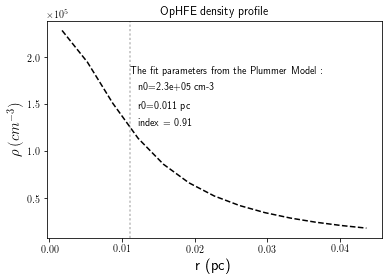

In [4]:
### Density Profile
n_flat,r_flatinpc,index= cfs.plummerparameter(vPars[0],vPars[1],vPars[2])
print("n_flat=",n_flat,"cm-3")
print("r_flatinpc=",r_flatinpc)
print("index=" ,index)
radiusinpc = radius*distinpc*AU/pc
n = n_flat/(1+(radiusinpc/r_flatinpc)**2)**index 
outputfilename =  fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]
save_path = './figures/'
outputfigureden = os.path.join(save_path, outputfilename + '_density' +".eps")
ranger1 = max(n)-0.20*max(n)
ranger2 = ranger1 -0.08*max(n)
ranger3 = ranger2 -0.08*max(n)
ranger4 = ranger3 -0.08*max(n)
plt.plot(radiusinpc,n,'k--')
plt.ylabel(r'$ \rho \, (cm^{-3})$', fontsize=15)
plt.xlabel(r'r (pc)',fontsize=15)
plt.axvline(x=r_flatinpc,linewidth=0.4,color='k',ls=':')
plt.text(r_flatinpc,ranger1, 'The fit parameters from the Plummer Model :' )
plt.text(r_flatinpc+0.001,ranger2, 'n0=%s   cm-3'% '%.1e' % Decimal(n_flat) )
plt.text(r_flatinpc+0.001,ranger3, 'r0=%s   pc'% round(r_flatinpc,3) )
plt.text(r_flatinpc+0.001,ranger4, 'index = %s'% round(index,2) )
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
plt.title(outputfilename +' density profile')
# plt.yscale('log')
plt.savefig(outputfigureden,format='eps',dpi=300)
plt.show()

In [5]:
from uncertainties import ufloat
eta = ufloat(vPars[2],unc[2])+0.5
print(eta)
r_fl = ufloat(vPars[1],unc[1])*distinpc*AU
# print(r_flat)
print(r_fl/pc)
def Ap(u):
    return 1/ (1+u**2)**index
def bounds_u():
    return [-2500, 2500]
result = integrate.nquad(Ap, [bounds_u])
    
n_fl=ufloat(vPars[0],unc[0])/r_fl/result[0]
print(n_fl.n,n_fl.s)
Plummermodel_error = [eta.s,r_fl.s/pc,n_fl.s]

0.91+/-0.16
0.011+/-0.004
233623.3300568523 93904.90117668077


In [6]:
# reading the saturated radius and the vel disper from file

filenametrasonicradius = "./transonic_data/" + fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+'rt.txt'
filenametrasonicsigma  = "./transonic_data/" + fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+'sigmat.txt'
r_cc_file = mf.readfilefortransonicdata(filenametrasonicradius)
r_c = np.asarray(r_cc_file)
# r_c = np.asarray(80)
rc = r_c*distinpc*4.84814e-6 # in pc 
sigma_NT_C_file = mf.readfilefortransonicdata(filenametrasonicsigma)
sigma_NT_C = np.asarray(sigma_NT_C_file)*(10**5)
print(sigma_NT_C)
print("sigma_NC=",sigma_NT_C,"cm/s \n","rc =",rc,"pc")
#### magnetic field with error ### 
# sigma_NT_C = 24589.090
# rc = 0.05
beta = 0.5
nc = n_flat/(1+(rc/r_flatinpc)**2)**index
print("nc=",nc)
B_cc = (sigma_NT_C  *(4* np.pi*mu* nc)**(.5))/beta

print("B_cc =" , B_cc," Gauss")

B1= (B_cc *(n/nc)**(1/2))*10**6 
print("B1=",B1)
B2 = (B_cc *(n/nc)**(2/3))*10**6 

[ 24066.02287225]
sigma_NC= [ 24066.02287225] cm/s 
 rc = [ 0.03577663] pc
nc= [ 25618.21051019]
B_cc = [  5.37175634e-05]  Gauss
B1= [ 160.43682504  148.12292483  130.4529803   113.21074442   98.52586002
   86.564179     76.89833785   69.03836977   62.57365744   57.18869739
   52.64716321   48.77249148   45.4318553 ]


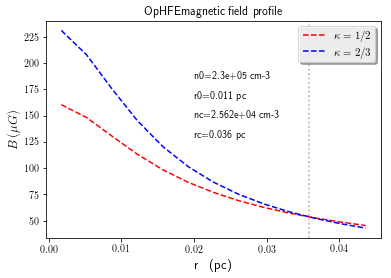

In [7]:
rangey1 = max(B2)-0.20*max(B2)
rangey2 = rangey1 -0.08*max(B2)
rangey3 = rangey2 - 0.08*max(B2)
rangey4 = rangey3 -0.08*max(B2)
plt.plot(radiusinpc,B1,'r--',label=r'$\kappa=1/2$')
plt.plot(radiusinpc,B2,'b--',label=r'$\kappa=2/3$')
plt.legend(numpoints=1,fancybox=True,shadow=True,fontsize=11,loc=1)
plt.ylabel(r'$ B \, (\mu G)$', fontsize=13)
plt.xlabel(r'r \, (pc) ',fontsize=13)
plt.axvline(x=rc,linewidth=0.4,color='k',ls=':')
# plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma)) 
plt.text(0.02,rangey1, 
         'n0=%s   cm-3'% '%.1e' % Decimal(n_flat) )
plt.text(0.02,rangey2, 'r0=%s   pc'% round(r_flatinpc,3) )
plt.text(0.02,rangey3, 'nc=%s   cm-3'% '%.3e' % nc )
plt.text(0.02,rangey4, 'rc=%s   pc'% '%.3f' %(rc))
plt.title(outputfilename + 'magnetic field profile')
outputfiguremag = os.path.join(save_path, outputfilename + 'magfield' +".eps")
plt.savefig(outputfiguremag,format='eps',dpi=300)
plt.show()

In [8]:
# To plot the variation of deltaB/B as  a function of R
## read the data file in fp
veldispfilename = "./data_sigma/"+ fileName[21]+fileName[22]+fileName[23]+fileName[24]+fileName[25]+"_sigmav.dat"
filename = veldispfilename
print(filename)
# fileName = "./data_sigma/H-MM2_column_density.dat"
# fileName = "./data_sigma/OpHCN_column_density.dat"
# fileName = "./data_sigma/OpH-C_column_density.dat"
# fileName = "./data_sigma/OpH-E_column_density.dat"
# fileName = "./data_sigma/OpH-X_column_density.dat"
# fileName = "./data_sigma/OpHFE_column_density.dat"
fp = open (filename,'r')
## Declaring an empty list to store the data from the .dat file
radius1_list = []  # units cm 
vthermal_list= []      # units cm^{-3}
vthermalerror_list = []
vnontherma_list = []
vnonthermaerror_list = []


## Reading the data from a .dat file line by line
for line in fp:
    t = line.strip().split()  
    radius1_list.append(float(t[0]))
    vthermal_list.append(float(t[1]))
    vthermalerror_list.append(float(t[2]))
    vnontherma_list.append(float(t[3])) 
    vnonthermaerror_list.append(float(t[4]))
    
fp.close()
radius1= np.asarray(radius1_list)
# converting to kms^-1
vthermal = np.asarray(vthermal_list)*10**-3
vnontherma =np.asarray(vnontherma_list)*10**-3
vthermalerror = np.asarray(vthermalerror_list)*10**-3
vnonthermaerror = np.asarray(vnonthermaerror_list)*10**-3

./data_sigma/OpHFE_sigmav.dat


In [9]:
save_path3 = './deltaB_data/'

delta_B_file = os.path.join(save_path3, outputfilename + 'deltaB_variation' +".dat")

In [10]:
def delta_B_error(index,r_flatinpc, n_flat,Plummermodel_error,sigma_NT,sigma_nonthermal_err,sigma_NT_C,rc_,r, k):
    

    '''
    Created on 6 May 2018
    This function estimate the disribution of B field at a particular radius
    Input Parameter : index 
                    : r_flatinpc
                    : n_flat
                    : sigma_NT_c
                    : The fit error of the Plummer Model (added on 23/04/18)
                    : radius at which the field is estiamtes
                    : k the \kappa for the flux freezing model
    
    
    Modified        : 7 August 2018
                    : added the error in the variation of rc and 
    '''
    delta_B_sigma = []
    delta_B_mean = []
    deltaB_overB_sigma = []
    
#     B_1quartile = []
#     B_3quartile = []
    npts = 1000
    nsim = 1000
    beta = 0.5
    ## the error were added on 23 April 2018
    eta_err = Plummermodel_error[0]
    r_0_err = Plummermodel_error[1]
    n_0_err = Plummermodel_error[2]
    ## the theory at each radius for each simulation we get a B profile and we estimate the mean, 1st quartile and 
    ## 3rd quartile and B_sigma. Then we run 1000 simulations and take the mean of the above quantity. 
    for i in range (1, nsim):
        power= index + np.random.standard_normal((npts,))*eta_err
        r_0 = r_flatinpc  + np.random.standard_normal((npts,))*r_0_err
        n_0 = n_flat + np.random.standard_normal((npts,))*n_0_err
        Sigma_NT = sigma_NT + np.random.standard_normal((npts,))*sigma_nonthermal_err
        Sigma_NT_C = sigma_NT_C + np.random.standard_normal((npts,))*0.1*sigma_NT_C ## added 10% variation to sigma_{NT} by hand
        rc = rc_ + np.random.standard_normal((npts,))*0.1*rc_ ## added 10% variation to sigma_{NT} by hand 
        n_c = n_0/(1+(rc/r_0)**2)**power
#         beta = np.random.uniform(0.5,0.8,npts)
        B_c = (Sigma_NT_C  *(4* np.pi*mu* np.abs(n_c))**(.5))/beta
        
        n = n_0/(1+(r/r_0)**2)**power
        
        delta_B = Sigma_NT* np.sqrt(4*np.pi*mu*np.abs(n))*10**6 ##### main output 
      
       
        B = (B_c *(n/n_c)**k) *10**6
        
        deltaB_overB = delta_B/B  ####### main output
        
        delta_B_sig = np.std(delta_B)
        delta_B_sigma.append(delta_B_sig)
        delta_B_mean.append(np.mean(delta_B))
        delta_B_sigma.append(delta_B_sig)
        deltaB_overB_sig = np.std(deltaB_overB)
        deltaB_overB_sigma.append(deltaB_overB_sig)
#         B_mean.append(np.mean(B))
#         B_1quartile.append(np.percentile(B,25))
#         B_3quartile.append(np.percentile(B,75))
        
    return (delta_B_mean,delta_B_sigma,deltaB_overB_sigma)

In [11]:
print(index,r_flatinpc, n_flat,Plummermodel_error,sigma_NT_C,rc)

0.911330254793 0.0111434899872 233623.330057 [0.16441023531802187, 0.00446372490717811, 93904.90117668077] [ 24066.02287225] [ 0.03577663]


In [12]:
radiusforplot = radius1*distinpc*4.84814e-6 # in pc 
mean_delta_B =[]
delta_B_sigma_mean = []
deltaB_overB_sigma_mean_k1 = []
deltaB_overB_sigma_mean_k2 = []
for j in range(0, len(radiusforplot), 1):
# for j in range(0, 1, 1):
    k1 =1/2
    k2 =2/3
    r = radiusforplot[j]
    sigma_NT = vnontherma[j] *10**5 ## converting to cm s^-1
    sigma_NT_err =vnonthermaerror[j] *10**5
    delta_B_mean,delta_B_sigma,deltaB_overB_sigma_k1 = delta_B_error(index,r_flatinpc, n_flat,
                                                        Plummermodel_error,sigma_NT,sigma_NT_err,sigma_NT_C,rc,r,k1)
    delta_B_mean,delta_B_sigma,deltaB_overB_sigma_k2 = delta_B_error(index,r_flatinpc, n_flat,
                                                        Plummermodel_error,sigma_NT,sigma_NT_err,sigma_NT_C,rc,r,k2)
    delta_B_sigma_mean_list = np.mean(delta_B_sigma)
    delta_B_sigma_mean.append(delta_B_sigma_mean_list)
    mean_delta_B.append(np.mean(delta_B_mean))
    deltaB_overB_sigma_mean_k1_list = np.mean(deltaB_overB_sigma_k1)
    deltaB_overB_sigma_mean_k1.append(deltaB_overB_sigma_mean_k1_list)
    deltaB_overB_sigma_mean_k2_list = np.mean(deltaB_overB_sigma_k2)
    deltaB_overB_sigma_mean_k2.append(deltaB_overB_sigma_mean_k2_list)

In [13]:
print(mean_delta_B)


[24.147038366886047, 20.679791700546357, 20.166126094245019, 21.725577149957683, 22.967590470542323, 25.949804121758316, 26.054910421528376, 25.198963965836679, 20.932312657386291, 16.955181048311854, 16.907464974859849, 16.796844782443532, 14.847986864363111, 12.564758411325208, 9.4003061273127386]


\Sigma_NT
 [  7780.   8270.  10100.  13300.  16700.  21900.  25000.  27100.  24900.
  22100.  23900.  25600.  24300.  21900.  17400.]
sqrt=  [ 469.04337183  388.69866095  307.21467564  247.64260914  205.70778688
  175.4389221   152.82107559  135.36952555  121.53037564  110.30112654
  101.01263382   93.20375822   86.54746821   80.80589385   75.80212018]
deltaB,
 [ 25.44486726  22.41434971  21.63569853  22.96595986  23.95382059
  26.7903048   26.63979326  25.57983785  21.10045289  16.99729497
  16.83376211  16.63722842  14.66453279  12.33941989   9.19683068]


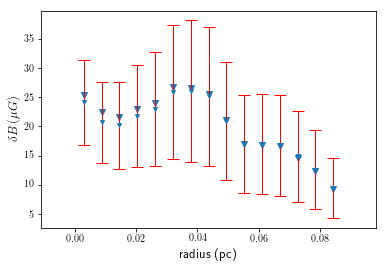

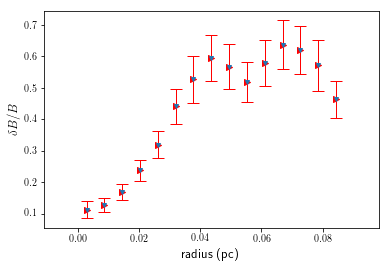

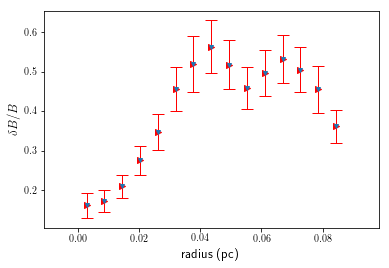

In [14]:
radiusforplot = radius1*distinpc*4.84814e-6 # in pc 
nplot = n_flat/(1+(radiusforplot/r_flatinpc)**2)**index 
B1= (B_cc *(nplot/nc)**(1/2))*10**6 
B2= (B_cc *(nplot/nc)**(2/3))*10**6
# print("B1=", B1)
# print("n=",n,
#       "B=",B1,
#       "Radius=", radiusforplot)
save_path = './figures/'
deltaB = vnontherma*10**5 * np.sqrt(4*np.pi*mu*nplot)*10**6
deltaBoverB_k1 = deltaB/B1
deltaBoverB_k2 = deltaB/B2


# print(deltaB)
print("\Sigma_NT\n", vnontherma*10**5)
print("sqrt= ", np.sqrt(nplot))
print("deltaB,\n",deltaB)
Data_deltaB = np.column_stack((radiusforplot,deltaB,mean_delta_B,delta_B_sigma_mean,
                               deltaBoverB_k1,deltaB_overB_sigma_mean_k1,deltaBoverB_k2,deltaB_overB_sigma_mean_k2))
np.savetxt(delta_B_file,Data_deltaB, fmt=('%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e'))

                    ## this is without the mean delta B#########
# Data_deltaB = np.column_stack((radiusforplot,deltaB,,delta_B_sigma_mean,
#                                deltaBoverB_k1,deltaB_overB_sigma_mean_k1,deltaBoverB_k2,deltaB_overB_sigma_mean_k2))
# np.savetxt(delta_B_file,Data_deltaB, fmt=('%5.3e',,'%5.3e','%5.3e','%5.3e','%5.3e','%5.3e','%5.3e'))
plt.figure(1)
plt.scatter(radiusforplot,deltaB, marker="v")
plt.errorbar(radiusforplot,mean_delta_B,yerr=delta_B_sigma_mean,lw=0,elinewidth=1,
             ecolor='r', fmt='v',markersize=4,capsize=6,label=r'$\rm{B_{new}\, model}$')
plt.ylabel(r'$\delta B \, (\mu G) $',fontsize=13)
plt.xlabel(r'radius (pc) ',fontsize=13)
outputfiguremag1 = os.path.join(save_path, 'H_MM1' + 'delta_B' +".png")
plt.savefig(outputfiguremag1,format='png',dpi=300)
plt.figure(2)
plt.scatter(radiusforplot,deltaBoverB_k2, marker=">",c = 'r')
plt.errorbar(radiusforplot,deltaBoverB_k2,yerr=deltaB_overB_sigma_mean_k2,lw=0,elinewidth=1,
             ecolor='r', fmt='v',markersize=4,capsize=6,label=r'$\rm{B_{new}\, model}$')
plt.ylabel(r'$\delta B /B $',fontsize=13)
plt.xlabel(r'radius (pc) ',fontsize=13)
plt.figure(3)
plt.scatter(radiusforplot,deltaBoverB_k1, marker=">",c = 'r')
plt.errorbar(radiusforplot,deltaBoverB_k1,yerr=deltaB_overB_sigma_mean_k1,lw=0,elinewidth=1,
             ecolor='r', fmt='v',markersize=4,capsize=6,label=r'$\rm{B_{new}\, model}$')
plt.ylabel(r'$\delta B /B $',fontsize=13)
plt.xlabel(r'radius (pc) ',fontsize=13)
outputfiguremag2 = os.path.join(save_path, 'H_MM1' + 'delta_BoverB' +".png")
plt.savefig(outputfiguremag2,format='png',dpi=300)
plt.show()

In [15]:

B_test = (((vnontherma*10**5)*(4* np.pi*mu* nplot)**(.5))/beta)*10**6
B_test_in = (((vthermal*10**5*2*np.sqrt(2*np.pi))  *(0.9*mu* nplot)**(.5)))*10**6
print(B_test,B_test_in)

[ 50.88973453  44.82869942  43.27139706  45.93191973  47.90764118
  53.58060959  53.27958652  51.15967569  42.20090577  33.99458994
  33.66752422  33.27445685  29.32906558  24.67883979  18.39366135] [ 101.79930901   84.36161233   65.81445396   51.19900096   45.60819868
   41.03078265   33.73953532   30.6464458    27.96815317   25.4871188
   24.19131644   22.40837635   20.48418696   18.67169884   17.01909399]


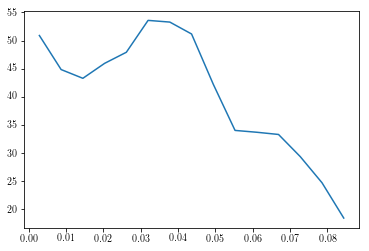

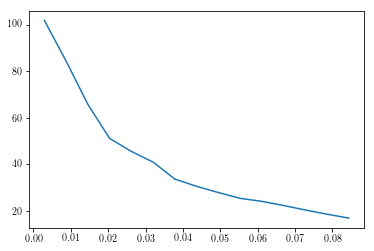

In [16]:
plt.plot(radiusforplot, B_test)
plt.show()
plt.plot(radiusforplot, B_test_in)
plt.show()


In [17]:
print(rc)

[ 0.03577663]


In [18]:
print (mu)

3.869058666e-24


In [19]:
print(vnonthermaerror)

[ 0.013    0.0099   0.00929  0.0108   0.0125   0.0138   0.0219   0.0146
  0.015    0.0112   0.0125   0.011    0.011    0.0173   0.00845]


In [20]:
len(radiusforplot[<rc])

SyntaxError: invalid syntax (<ipython-input-20-da38acdcc708>, line 1)

In [ ]:
print(rc)

In [ ]:
print(radiusforplot[radiusforplot<rc])

In [ ]:
vnontherma[radiusforplot<rc]